# Functions

In [6]:
from app.utils.functions import execute_sp, get_mapping
import pandas as pd

In [7]:
res = await execute_sp(
    "dbo.sp_simBudLines",
    {
        "user_fk": 8,
        "form_fk": 167,
        "line_fk": 0,
        "choix": 0,
        "isVisible": 1
    }
)

In [8]:
def create_simplified_hierarchy(flat_data: (list[dict])):
    """
    Generates a hierarchy from a flat list, keeping only the 'label' and 'children' fields for each node.

    Args:
        flat_data (list[dict]): List of dictionaries describing flat nodes.
            Each dict must have at least 'line_id', 'parent_fk', 'label'.

    Returns:
        list[dict]: Hierarchical tree of simplified nodes with only 'label' and 'children'.
    """
    index_by_id = {}
    children_by_parent = {}
    roots = []

    for item in flat_data:
        node = item.copy()
        current_id = node['line_id']
        parent_id = node['parent_fk'] if node['parent_fk'] != 'NULL' else None

        index_by_id[current_id] = node

        if parent_id is None:
            roots.append(current_id)
        else:
            children_by_parent.setdefault(parent_id, []).append(current_id)

    def build_simplified_node(node_id):
        """Recursively constructs a simplified node from its ID."""
        node_label = index_by_id[node_id]['label']
        children_ids = children_by_parent.get(node_id, [])
        children_list = [build_simplified_node(child_id) for child_id in children_ids]
        return {'label': node_label, 'children': children_list}

    return [build_simplified_node(root_id) for root_id in roots]

simple_dict = create_simplified_hierarchy(res)

In [9]:
def get_children_by_label(data: list[dict], target_label: str):
    """
    Recherche un label donné dans une structure arborescente (liste de dictionnaires
    imbriqués avec 'label' et 'children') et retourne la liste des labels de ses enfants.

    :param data: La liste des noeuds racine de la structure (votre liste principale).
    :param target_label: Le label (chaîne de caractères) dont on cherche les enfants.
    :return: Une liste de chaînes de caractères (les labels des enfants) ou None si le label n'est pas trouvé.
    """
    if not isinstance(data, list):
        return None

    for node in data:
        if node.get('label') == target_label:
            return [child.get('label') for child in node.get('children', [])]

        if node.get('children'):
            result = get_children_by_label(node['children'], target_label)
            
            if result is not None:
                return result
    
    return None

In [10]:
label_cible_1 = "RECETTES ANNEXES"
enfants_1 = get_children_by_label(simple_dict, label_cible_1)
print(f"Enfants de '{label_cible_1}' :")
print(enfants_1)

label_cible_1 = "CA petits déjeuners"
enfants_1 = get_children_by_label(simple_dict, label_cible_1)
print(f"Enfants de '{label_cible_1}' :")
print(enfants_1)

Enfants de 'RECETTES ANNEXES' :
['CA petits déjeuners', 'CA Frais locatif', 'CA Séminaire (loc. de salle)', 'CA Restauration', 'CA Laverie-Ménage', 'CA Billeterie', 'CA Taxe de séjours', 'CA Divers', "Subvention d'exploitation (Rbst format°)", 'CA Communication', 'Produits Divers', 'Charges de copro récupérables', 'CA Spa']
Enfants de 'CA petits déjeuners' :
['Recettes petits-déjeuners', 'CA petits déjeuners']


In [11]:
df = pd.read_csv(r"tests\data.csv")

In [12]:
def generate_hierarchy_codes(data, parent_code=""):
    """
    Génère les codes hiérarchiques dans l'arbre (modification In-Place).
    """
    if not isinstance(data, list):
        return []

    for index, node in enumerate(data):
        current_level_num = index + 1
        new_code = f"{parent_code}{current_level_num}."
        node['code'] = new_code
        if 'children' in node and node['children']:
            generate_hierarchy_codes(node['children'], new_code)
    return data

In [13]:
def extract_flat_hierarchy_list(data):
    """
    Extrait tous les labels et leurs codes dans une liste plate.
    """
    flat_list = []
    if not isinstance(data, list):
        return flat_list
    for node in data:
        flat_list.append({
            'label': node.get('label'),
            'code': node.get('code')
        })
        if 'children' in node and node['children']:
            flat_list.extend(extract_flat_hierarchy_list(node['children']))
    return flat_list

In [14]:
def get_descendant_labels(node):
    """Fonction récursive pour extraire tous les labels descendants d'un nœud."""
    labels = []
    for child in node.get('children', []):
        labels.append(child['label'])
        labels.extend(get_descendant_labels(child))
        
    return labels

In [15]:
def extract_all_descendants_for_list(data_list):
    """
    Pour chaque élément de la liste de niveau supérieur, extrait la liste de tous ses descendants.
    
    :param data_list: La liste principale des dictionnaires hiérarchiques.
    :return: Une liste de listes, où chaque sous-liste contient les labels des descendants.
    """
    result = []
    for i, item in enumerate(data_list):
        descendant_labels = get_descendant_labels(item)
        descendant_labels.append(data_list[i]['label'])
        result.append(descendant_labels)
    return result

In [16]:
def preprocessing_data(df: pd.DataFrame, simple_dict: list[dict]) -> pd.DataFrame:
    """Prétraite et catégorise le DataFrame selon les groupes définis."""
    try:
        required_columns = ['Lignes', 'Contexte', 'Nature de l\'écriture', 'Année', 'Mois', 'Montant']
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"La colonne requise '{col}' est absente du DataFrame.")
        mask = (
            (df.iloc[:, 0] == df.iloc[0, 0]) &
            (df.iloc[:, 2] == "Compte d'exploitation") &
            (df.iloc[:, 8] != "Colonne variation")
        )
        df_filtered = df[mask].copy()
        # Règle spéciale pour "% DES RECETTES TOTALES" : code 10 + tri des montants.
        mask_pct_recettes = df_filtered['Lignes'] == "% DES RECETTES TOTALES"
        df_pct_recettes = df_filtered[mask_pct_recettes].copy()
        df_autres = df_filtered[~mask_pct_recettes].copy()
        if not df_pct_recettes.empty:
            # Tri décroissant sur montant (attention, convertir colonne si besoin)
            df_pct_recettes = df_pct_recettes.sort_values("Montant", ascending=False).reset_index(drop=True)
            code_map = {0: 4, 1: 7, 2: 10}
            df_pct_recettes['Code Hiérarchique'] = df_pct_recettes.index.map(lambda idx: code_map.get(idx, 10))
        # Codage standard pour les autres lignes
        coded_tree = generate_hierarchy_codes(simple_dict)
        hierarchy_list = extract_flat_hierarchy_list(coded_tree)
        mapping_dict = {item['label']: item['code'] for item in hierarchy_list}
        if not df_autres.empty:
            df_autres['Code Hiérarchique'] = df_autres['Lignes'].map(mapping_dict)
        # Fusionne le tout (en gardant le bon ordre d'origine)
        df_filtered = pd.concat([df_autres, df_pct_recettes]).sort_index(kind="stable")
        cols = list(df.columns)
        if "Code Hiérarchique" in cols and "Lignes" in cols:
            cols.remove("Code Hiérarchique")
            insert_idx = cols.index("Lignes")
            cols = cols[:insert_idx] + ["Code Hiérarchique"] + cols[insert_idx:]
            df_filtered = df_filtered[cols]
        result_list = extract_all_descendants_for_list(simple_dict)
        CHIFFRE_AFFAIRES = result_list[0] + result_list[3] + result_list[6] + result_list[9] + result_list[10]
        CHARGES = result_list[1] + result_list[4] + result_list[7] + result_list[12]
        MARGES = result_list[2] + result_list[5] + result_list[8] + result_list[11] + result_list[13]
        groupes_dict = {
            "Chiffre d'affaire": CHIFFRE_AFFAIRES,
            "Charge": CHARGES,
            "Marge": MARGES
        }
        groupes_mapping = {poste: groupe for groupe, postes in groupes_dict.items() for poste in postes}
        df_filtered['Groupe'] = df_filtered['Lignes'].map(groupes_mapping)
        df_filtered = df_filtered.drop_duplicates().reset_index(drop=True)
        return df_filtered
    except:
        pass

In [17]:
df = preprocessing_data(df, simple_dict)

In [18]:
import re
from datetime import datetime
import unicodedata, spacy
from thefuzz import fuzz

In [19]:
nlp = spacy.load("fr_core_news_md")

In [20]:
synonymes_groupes = await get_mapping()

In [42]:
async def parse_user_query(
    query: str, 
    synonymes_groupes: dict[str, list[str]], 
    simple_dict: list[dict]) -> dict[str, list[str]]:
    """Transforme une question utilisateur en paramètres de fonction."""
    def _strip_accents(text: str) -> str:
        """
        Supprime les accents et normalise la casse/ponctuation dans une chaîne pour faciliter les comparaisons.
        """
        if not isinstance(text, str) or not text.strip():
            return ""
        s = (
            text.replace("’", "'")
                .replace("`", "'")
                .replace("‘", "'")
                .replace("–", "-")
                .replace("—", "-")
        )
        s = unicodedata.normalize("NFD", s)
        s = ''.join(
            c for c in s
            if unicodedata.category(c) != 'Mn'
        )
        s = re.sub(r"\s+", " ", s.lower()).strip()
        return s

    async def _check_detail(question: str, threshold: int = 80) -> bool:
        question_norm = _strip_accents(question.lower())
        res = await get_mapping()
        keywords_details: list[str] = res["Détail"]
        for kw in keywords_details:
            if fuzz.partial_ratio(question_norm, _strip_accents(kw.lower())) > threshold:
                return True
        return False

    async def _get_col_info(question: str, threshold: int = 90) -> dict|None:
        lst = await execute_sp(
            "dbo.sp_simBudCol",
            {
                "user_fk": 8,
                "codeMetier": 'EXP',
                "form_fk": 167,
                "codeFormType": None,
                "type_fk": 0,
                "colYear_fk": 0
            }
        )
        df_col = pd.DataFrame(lst)
        df_col = df_col[df_col["labelType"]=="Année contexte"][["label", "RB", "Mois", "theYear"]].copy()
        
        q = _strip_accents(question.lower())
        q_tokens = set(re.findall(r"\w+", q))
        LISTE_LIGNES: list[str] = df_col["label"].to_list()
        results = {}
        for ligne in LISTE_LIGNES:
            ln = _strip_accents(ligne.lower())
            ln_tokens = set(re.findall(r"\w+", ln))
            if ln_tokens and ln_tokens.issubset({str(t).rstrip('s') for t in q_tokens} | q_tokens):
                results[ligne] = 100
                continue
            score = fuzz.token_set_ratio(q, ln)
            if score >= threshold:
                results[ligne] = max(results.get(ligne, 0), score)
        if results:
            line = df_col[df_col["label"] == sorted(results.items(), key=lambda x: -x[1])[0][0]]
            return {
                "label": line["label"].iloc[0],
                "annee": int(line["theYear"].iloc[0]),
                "mois": int(line["Mois"].iloc[0]),
                "contexte": line["RB"].iloc[0]
            }    
        else:
            None

    doc = nlp(query)
    query_lower = query.lower()
    params = {
        'groupes': [],
        'types_valeur': [],
        'annees': [],
        'nature_ecriture': [],
        'lignes': [],
        'mois': []
    }
    col_infos = await _get_col_info(query_lower)

    # GROUPE
    def _select_groupe(question: str, threshold: float = 70) -> list:
        query_norm = _strip_accents(question)

        best_matches: dict[str, float] = {}
        max_overall_score = 0.0

        for g, mots in list(synonymes_groupes.items())[:3]:
            max_group_score = 0.0
            for m in mots:
                m_norm = _strip_accents(m)
                score = fuzz.token_set_ratio(query_norm, m_norm)
                if score > max_group_score:
                    max_group_score = score
                    
            best_matches[g] = max_group_score
            
            if max_group_score > max_overall_score:
                max_overall_score = max_group_score
        res = []
        if max_overall_score >= threshold:
            score_tolerance = 5
            for g, score in best_matches.items():
                if score >= threshold and score >= (max_overall_score - score_tolerance):
                    res.append(g)
        return res
    params['groupes'] = _select_groupe(query_lower)

    # TYPE DE VALEUR
    def _define_contexte(question: str) -> list:
        types_valeur = set()
        query_lower_noacc = _strip_accents(question)
        if re.search(r"reel|realise|actuel", query_lower_noacc):
            types_valeur.add('R')
        if re.search(r"budget", query_lower_noacc):
            types_valeur.add('B')
        if re.search(r"prevision|prevu|projection|project|prev", query_lower_noacc):
            types_valeur.add('P')
        for ent in doc.ents:
            ent_text_noacc = _strip_accents(ent.text.lower())
            if ent.label_ == "MISC":
                if re.search(r"reel|realise|actuel", ent_text_noacc):
                    types_valeur.add('R')
                if re.search(r"budget", ent_text_noacc):
                    types_valeur.add('B')
                if re.search(r"prevision|prevu|projection|project|prev", ent_text_noacc):
                    types_valeur.add('P')
        return sorted(types_valeur)
    params['types_valeur'] = _define_contexte(query_lower)

    # ANNEE
    def _define_year(question: str) -> list:
        annees = set(map(int, re.findall(r"\b20\d{2}\b", question)))
        
        pattern_2digit = r"\b(?:Budget|Réel|Reel)\s*'?(\d{2})\b"
        matches_2digit = re.findall(pattern_2digit, question, re.IGNORECASE)
        for match in matches_2digit:
            yy = int(match)
            if yy < 50:
                year = 2000 + yy
            else:
                year = 1900 + yy
            annees.add(year)

        for ent in doc.ents:
            if ent.label_ == "DATE":
                if ent.text.isdigit() and len(ent.text) == 4 and ent.text.startswith("20"):
                    annees.add(int(ent.text))
                elif re.match(r"20\d{2}[-/ ]20\d{2}", ent.text):
                    annees.update(map(int, re.findall(r"20\d{2}", ent.text)))
                else:
                    annees.update(map(int, re.findall(r"20\d{2}", ent.text)))

                ent_matches = re.findall(pattern_2digit, ent.text, re.IGNORECASE)
                for em in ent_matches:
                    yy = int(em)
                    if yy < 50:
                        year = 2000 + yy
                    else:
                        year = 1900 + yy
                    annees.add(year)

        interval_patterns_annee = [
            r"(?:entre)\s+20(\d{2})\s+(?:et)\s+20(\d{2})",
            r"(?:de)\s+20(\d{2})\s+(?:à|a)\s+20(\d{2})"
        ]
        for pat in interval_patterns_annee:
            m = re.search(pat, question)
            if m:
                y1, y2 = int("20" + m.group(1)), int("20" + m.group(2))
                if y1 <= y2:
                    annees.update(range(y1, y2 + 1))
                else:
                    annees.update(range(y2, y1 + 1))

        if annees:
            return sorted(annees)
        else:
            if re.search(r"cette (année|annee)", question):
                return [datetime.now().year]
            elif re.search(r"(année|annee) dernière|an dernier|(année|annee) (passée|passee)|(année|annee) (précédente|precedente)", question):
                return [datetime.now().year - 1]
            elif re.search(r"(l'année|l'annee) prochaine|l'an prochain", question):
                return [datetime.now().year + 1]
    params['annees'] = _define_year(query_lower)

    # MOIS
    def _define_month(question: str) -> list:
        mois_map = {
            1: [r"janv(?:ier)?", r"jan"],
            2: [r"f[ée]vr(?:ier)?", r"fev"],
            3: [r"mars?", r"mar"],
            4: [r"avr(?:il)?", r"avr"],
            5: [r"mai"],
            6: [r"juin"],
            7: [r"juil(?:let)?", r"jul"],
            8: [r"ao[uû]t?", r"aou"],
            9: [r"sept(?:embre)?", r"sep"],
            10: [r"oct(?:obre)?", r"oct"],
            11: [r"nov(?:embre)?", r"nov"],
            12: [r"d[ée]c(?:embre)?", r"dec"],
        }

        query_norm = _strip_accents(question)
        mois = set()
        interval_patterns = [
            r"(?:entre)\s+([a-zéûî\.]+)\s+(?:et)\s+([a-zéûî\.]+)",
            r"(?:de)\s+([a-zéûî\.]+)\s+(?:à|a)\s+([a-zéûî\.]+)",
        ]
        interval_match = None
        for pat in interval_patterns:
            m = re.search(pat, query_norm)
            if m:
                interval_match = m
                break

        if interval_match:
            mois1_txt, mois2_txt = interval_match.groups()
            mois1_txt = mois1_txt.replace('.', '')
            mois2_txt = mois2_txt.replace('.', '')
            mois1_num, mois2_num = None, None
            for num, patterns in mois_map.items():
                for pat in patterns:
                    if re.fullmatch(pat, mois1_txt):
                        mois1_num = num
                    if re.fullmatch(pat, mois2_txt):
                        mois2_num = num
            if mois1_num and mois2_num:
                if mois1_num <= mois2_num:
                    mois = set(range(mois1_num, mois2_num + 1))
                else:
                    mois = set(list(range(mois1_num, 13 + 1)) + list(range(1, mois2_num + 1)))
        else:
            for num, patterns in mois_map.items():
                for pat in patterns:
                    if re.search(rf"\b{pat}\b", query_norm):
                        mois.add(num)

            trimestre_regex = [
                (r"\b(1(er)?|premier|i+)[s\-]*(trimestre|trim)\b", [1, 2, 3]),
                (r"\b(2(e|ème|eme)?|deuxi[eè]me|ii+)[s\-]*(trimestre|trim)\b", [4, 5, 6]),
                (r"\b(3(e|ème|eme)?|troisi[eè]me|iii+)[s\-]*(trimestre|trim)\b", [7, 8, 9]),
                (r"\b(4(e|ème|eme)?|quatri[eè]me|iv+)[s\-]*(trimestre|trim)\b", [10, 11, 12]),
            ]
            for pat, mois_list in trimestre_regex:
                if re.search(pat, query_norm):
                    mois.update(mois_list)
                    break

            semestre_regex = [
                (r"\b(1(er)?|premier|i+)[s\-]*(semestre|sem)\b", [1, 2, 3, 4, 5, 6]),
                (r"\b(2(e|ème|eme)?|deuxi[eè]me|ii+)[s\-]*(semestre|sem)\b", [7, 8, 9, 10, 11, 12]),
            ]
            for pat, mois_list in semestre_regex:
                if re.search(pat, query_norm):
                    mois.update(mois_list)
                    break

            if re.search(r"\btous les mois\b", query_norm):
                mois.update(range(1, 13))
            elif re.search(r"\bmois courant\b", query_norm):
                mois.update([datetime.now().month])
            elif re.search(r"\bmois dernier\b", query_norm):
                mois.update([datetime.now().month - 1 if datetime.now().month > 1 else 12])
            elif re.search(r"\bmois prochain\b", query_norm):
                mois.update([datetime.now().month + 1 if datetime.now().month < 12 else 1])
        return sorted(mois)
    params['mois'] = _define_month(query_lower)

    # NATURE ECRITURE
    def _select_nature_ecriture(question: str) -> list:
        nature_ecritures = set()
        if re.search(r"\b(mensuel(le)?|mois|trimestre|semestre|janvier|février|fevrier|mars|avril|mai|juin|juillet|août|aout|septembre|octobre|novembre|décembre|decembre)\b", question):
            nature_ecritures.add('Mensuelle')
        if re.search(r"\b(annuel(le)?|total|cette année|cette annee|année|annee)\b", question):
            nature_ecritures.add('Annuelle')
        if not nature_ecritures:
            if params.get('mois') and 0 < len(params['mois']) < 12:
                nature_ecritures.add('Mensuelle')
            if params.get('mois') and len(params['mois']) == 12:
                nature_ecritures.add('Annuelle')
        return [v for v in ['Mensuelle', 'Annuelle'] if v in nature_ecritures]
    params['nature_ecriture'] = _select_nature_ecriture(query_lower)

    # LIGNES
    async def _match_lignes(question: str, threshold: int = 75, return_scores: bool = False):
        result_list = extract_all_descendants_for_list(simple_dict)
        LISTE_LIGNES: list[str] = [label for sublist in result_list for label in sublist]
        q = _strip_accents(question.lower())
        q_tokens = set(re.findall(r"\w+", q))
        results = {}
        # Plus grande tolérance au singulier/pluriel : on compare formes singulier et pluriel, pour chaque token de la ligne et de la question
        def _sing_plur_forms(token):
            if token.endswith('s'):
                return {token, token[:-1]}
            else:
                return {token, token + 's'}
        
        for ligne in LISTE_LIGNES:
            ln = _strip_accents(ligne.lower())
            ln_tokens_raw = set(re.findall(r"\w+", ln))
            q_tokens_raw = q_tokens

            # Génère toutes formes singulier/pluriel pour ln_tokens et q_tokens
            ln_tokens_all = set()
            for t in ln_tokens_raw:
                ln_tokens_all.update(_sing_plur_forms(t))
            q_tokens_all = set()
            for t in q_tokens_raw:
                q_tokens_all.update(_sing_plur_forms(t))
            
            # Test : Tous les tokens 'ligne' (sing/plur) présents dans q (sing/plur)
            if ln_tokens_all and ln_tokens_all.issubset(q_tokens_all):
                results[ligne] = 100
                continue

            # Fallback fuzzy
            score = fuzz.token_set_ratio(q, ln)
            if score >= threshold:
                results[ligne] = max(results.get(ligne, 0), score)

        ordered = sorted(results.items(), key=lambda x: -x[1])
        detail = await _check_detail(question)
        if detail and ordered:
            enfants = []
            for l in ordered:
                enfants += get_children_by_label(simple_dict, l[0])
            return set(enfants + [lbl for lbl, _ in ordered])
        return ordered if return_scores else [lbl for lbl, _ in ordered]
    params['lignes'] = await _match_lignes(query_lower)

    # Correct for NoneType issues and robustify list usage
    if col_infos:
        annee = col_infos.get("annee")
        # Ensure params['annees'] is always a list
        if not isinstance(params.get('annees'), list) or params['annees'] is None:
            params['annees'] = []
        if annee is not None and annee not in params['annees']:
            params['annees'].append(annee)
        mois = col_infos.get("mois", 0)
        if not isinstance(params.get('nature_ecriture'), list) or params['nature_ecriture'] is None:
            params['nature_ecriture'] = []
        if mois == 0:
            if "Annuelle" not in params['nature_ecriture']:
                params['nature_ecriture'].append("Annuelle")
        else:
            if "Mensuelle" not in params['nature_ecriture']:
                params['nature_ecriture'].append("Mensuelle")
            if not isinstance(params.get('mois'), list) or params['mois'] is None:
                params['mois'] = []
            if mois not in params['mois']:
                params['mois'].append(mois)

        contexte = col_infos.get("contexte")
        if not isinstance(params.get('types_valeur'), list) or params['types_valeur'] is None:
            params['types_valeur'] = []
        if contexte and contexte not in params['types_valeur']:
            params['types_valeur'].append(contexte)

    # Normalize all params lists (ensure always list, de-duplicate, and sort if non-empty)
    for k in ['groupes', 'types_valeur', 'annees', 'nature_ecriture', 'lignes', 'mois']:
        param_val = params.get(k)
        if not isinstance(param_val, list) or param_val is None:
            params[k] = []
        else:
            params[k] = sorted(set(param_val)) if param_val else []

    if not params['nature_ecriture']:
        params['nature_ecriture'] = ['Annuelle']

    if not params['annees']:
        params['annees'] = [datetime.now().year]

    return params


In [22]:
def _strip_accents(text: str) -> str:
    """
    Supprime les accents et normalise la casse/ponctuation dans une chaîne pour faciliter les comparaisons.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    s = (
        text.replace("’", "'")
            .replace("`", "'")
            .replace("‘", "'")
            .replace("–", "-")
            .replace("—", "-")
    )
    s = unicodedata.normalize("NFD", s)
    s = ''.join(
        c for c in s
        if unicodedata.category(c) != 'Mn'
    )
    s = re.sub(r"\s+", " ", s.lower()).strip()
    return s

def _check_detail(question: str) -> bool:
    """
    Utilise 'fuzz' pour rechercher la présence de 'detail', 'details', ou 'detailles' dans la question,
    en tolérant les petites variations d'orthographe.
    """
    keywords = ["detail", "details", "detailles", "composante"]
    question_norm = _strip_accents(question.lower())
    for kw in keywords:
        if fuzz.partial_ratio(question_norm, kw) > 90:
            return True
    return False

result_list = extract_all_descendants_for_list(simple_dict)
LISTE_LIGNES = [label for sublist in result_list for label in sublist]

def match_lignes(question: str, threshold: int = 75, return_scores: bool = False):
    q = _strip_accents(question)
    q_tokens = set(re.findall(r"\w+", q))
    results = {}
    for ligne in LISTE_LIGNES:
        ln = _strip_accents(ligne)
        ln_tokens = set(re.findall(r"\w+", ln))
        # 1) Strong rule: all tokens of label present in question (with plural tolerance)
        if ln_tokens and ln_tokens.issubset({t.rstrip('s') for t in q_tokens} | q_tokens):
            results[ligne] = 100
            continue
        # 2) Fuzzy fallback
        score = fuzz.token_set_ratio(q, ln)
        if score >= threshold:
            results[ligne] = max(results.get(ligne, 0), score)
    # trier par score décroissant et retourner
    ordered = sorted(results.items(), key=lambda x: -x[1])
    detail = _check_detail(question)
    if detail and ordered:
        enfants = []
        for l in ordered:
            enfants += get_children_by_label(simple_dict, l[0])
        return set(enfants + [lbl for lbl, _ in ordered])
    return ordered if return_scores else [lbl for lbl, _ in ordered]
query = "Quelles sont les recettes réelles de 2024 ?"
query, match_lignes(query)

('Quelles sont les recettes réelles de 2024 ?', ['RECETTES'])

In [23]:
async def get_data_for_llm(
    df: pd.DataFrame,
    simple_dict: list[dict],
    types_valeur: list[str],
    nature_ecriture: list[str],
    sa_fk: int = 224,
    form_fk: int = 167,
    groupes: list[str] = None,
    mois: list = None,
    annees: list = None,
    lignes: list[str] = None) -> str:
    """
    Args:
        df (pd.DataFrame): DataFrame des écritures catégorisées à filtrer.
        simple_dict (list[dict]): Arbre hiérarchique des lignes/postes.
        types_valeur (list[str]): Types de valeur à inclure (ex: ['R', 'B']).
        nature_ecriture (list[str]): Types d'écriture à inclure (ex: ['Annuelle', 'Mensuelle']).
        groupes (list[str], optional): Groupes analytiques à filtrer. None = tous.
        mois (list[int], optional): Mois à inclure (ex: [1,2,3]). None = tous.
        annees (list[int], optional): Années à inclure (ex: [2024,2025]). None = toutes.
        lignes (list[str], optional): Postes/écritures à inclure. None = tous.
    Returns:
        is_not_empty (boolean): 
        df_markdown (str): Tableau Markdown filtré pour le prompt, ou texte vide si aucun résultat.
    """
    df_temp = df.copy()
    for col in ['Montant', 'Année', 'Mois']:
        if col in df_temp.columns:
            df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    df_temp['Groupe'] = df_temp['Groupe'].fillna('')

    filtres = (
        df_temp['Contexte'].str.lower().isin([t.lower() for t in types_valeur]) &
        df_temp["Nature de l'écriture"].str.lower().isin([n.lower() for n in nature_ecriture])
    )

    if annees:
        filtres &= df_temp['Année'].isin([int(a) for a in annees])

    if mois and len(mois) > 0:
        mois = [int(m) for m in mois]
        filtres = (
            filtres &
            (
                ((df_temp["Nature de l'écriture"].str.lower() == "mensuelle") & df_temp["Mois"].isin(mois)) |
                (df_temp["Nature de l'écriture"].str.lower() == "annuelle")
            )
        )
    
    filtres_hierarchie = df_temp['Code Hiérarchique'].apply(
        lambda x: isinstance(x, str) and x.count('.') <= 2
    )

    result_list = extract_all_descendants_for_list(simple_dict)
    CHIFFRE_AFFAIRES = result_list[0] + result_list[3] + result_list[6] + result_list[9] + result_list[10]
    CHARGES = result_list[1] + result_list[4] + result_list[7] + result_list[12]
    MARGES = result_list[2] + result_list[5] + result_list[8] + result_list[11] + result_list[13]

    if lignes and len(lignes) > 0 and groupes and len(groupes) > 0:
        lignes_valides_du_groupe: list[str] = []
        for groupe in groupes:
            if groupe == "Chiffre d'affaire":
                lignes_valides_du_groupe += CHIFFRE_AFFAIRES
            elif groupe == "Charge":
                lignes_valides_du_groupe += CHARGES
            elif groupe == "Marge":
                lignes_valides_du_groupe += MARGES
        
        toutes_lignes_coherentes = all(l in lignes_valides_du_groupe for l in lignes)
        
        if toutes_lignes_coherentes:
            filtres_lignes = df_temp["Lignes"].str.lower().isin([l.lower() for l in lignes])
            filtres &= filtres_lignes
        else:
            filtres_groupes = df_temp['Groupe'].str.lower().isin([g.lower() for g in groupes])
            filtres &= filtres_groupes
    elif lignes and len(lignes) > 0:
        filtres_lignes = df_temp["Lignes"].str.lower().isin([l.lower() for l in lignes])
        filtres &= filtres_lignes
    elif groupes and len(groupes) > 0:
        filtres_groupes = df_temp['Groupe'].str.lower().isin([g.lower() for g in groupes])
        filtres &= filtres_groupes
        filtres &= filtres_hierarchie
    else:
        filtres &= filtres_hierarchie

    df_filtre: pd.DataFrame = df_temp.loc[filtres].copy()

    all_annu = all(n.lower() == "annuelle" for n in nature_ecriture)
    all_mensu = all(n.lower() == "mensuelle" for n in nature_ecriture)

    def _code_to_tuple(code):
        if pd.isna(code):
            return (999999,)
        s = str(code).strip()
        if s.endswith('.'):
            s = s.rstrip('.')
        nums = re.findall(r'\d+', s)
        if not nums:
            return (999999,)
        return tuple(int(n) for n in nums)

    def _filter_constant_columns(cols):
        EXCLUDE = {"Lignes", "Montant"}
        if df_filtre is not None and len(df_filtre) > 0:
            constant_columns = cols.copy()
            for col_name in constant_columns:
                if col_name in EXCLUDE:
                    continue
                if col_name in df_filtre.columns and df_filtre[col_name].nunique() == 1:
                    cols = [c for c in cols if c != col_name]
        return cols

    def _flatten_labels(simple_dict: list[dict]) -> pd.DataFrame:
        def __flatten_labels(simple_dict: list[dict]) -> list[dict]:
            flat_list = []
            for item in simple_dict:
                label = item.get("label", "")
                code = item.get("code", "")
                flat_list.append({"code": code, "label": label})
                children = item.get("children", [])
                if children:
                    flat_list.extend(__flatten_labels(children))
            return flat_list
        return pd.DataFrame(__flatten_labels(simple_dict), columns=["code", "label"])

    def _code_parts_raw(code: str) -> list:
        if not isinstance(code, str):
            return []
        parts = code.split('.')
        parts = [p for p in parts if p != ""]
        return parts

    def _find_siblings_with_neighbors(
        label: str, 
        df_labels_codes: pd.DataFrame, 
        n_before: int = 0, 
        n_after: int = 0
    ) -> str:
        row_mask = df_labels_codes["label"] == label
        if not row_mask.any():
            return []

        idx = df_labels_codes.index[row_mask][0]
        code_central = df_labels_codes.at[idx, "code"]
        central_parts = _code_parts_raw(code_central)

        if len(central_parts) <= 1:
            def __is_root(c):
                return len(_code_parts_raw(c)) == 1

            df_roots = df_labels_codes[df_labels_codes["code"].apply(__is_root)].copy()
            label_idx_in_roots = df_roots.index[df_roots["label"] == label]
            if label_idx_in_roots.empty:
                return df_roots["label"].to_list()
            i = label_idx_in_roots[0]
            start = max(0, i - n_before)
            end = i + n_after + 1
            sel = df_roots.iloc[start:end]
            return sel["label"].to_list()

        parent_parts = central_parts[:-1]
        target_depth = len(central_parts)

        def __is_same_parent(c):
            parts = _code_parts_raw(c)
            if len(parts) != target_depth:
                return False
            cand_parent = parts[:-1]
            return cand_parent == parent_parts

        df_siblings = df_labels_codes[df_labels_codes["code"].apply(__is_same_parent)].copy()
        label_idx_in_siblings = df_siblings.index[df_siblings["label"] == label]
        if label_idx_in_siblings.empty:
            return df_siblings.reset_index(drop=True)["label"].to_list()
        i = label_idx_in_siblings[0]
        i_relative = list(df_siblings.index).index(i)
        start = max(0, i_relative - n_before)
        end = i_relative + n_after + 1
        sel: pd.DataFrame = df_siblings.iloc[start:end]
        return sel["label"].to_list()

    async def _detail_cell(
        sa_fk: int,
        theYear: int,
        context: str,
        theMonth: int,
        label: str,
        res: list[dict]
    ) -> pd.DataFrame:
        def __filter_columns_by_indices(df: pd.DataFrame, indices: list[int]):
            existing_indices = [i for i in indices if i < df.shape[1]]
            return df.iloc[:, existing_indices]

        def __get_line_fk(label: str, res: list[dict]=res):
            df = pd.DataFrame(res).iloc[:, [0, 4]]
            ser = df[df["label"] == label]["line_id"]
            return int(ser.iloc[0])

        lst = await execute_sp(
            "dbo.sp_simBudValueOne",
            {
                "user_fk": 8,
                "listSA": 0,
                "line_fk": __get_line_fk(label),
                "sa_fk": sa_fk,
                "listCR": 0,
                "cr_fk": 0,
                "theYear": theYear,
                "RB": context,
                "theMonth": theMonth
            }
        )
        if not lst or not isinstance(lst, list):
            return pd.DataFrame()
        
        indices_to_keep = [3, 10, 12, 14, 15]
        df = pd.DataFrame(lst)
        if df.shape[1] >= max(indices_to_keep) + 1:
            return __filter_columns_by_indices(df, indices_to_keep)
        else:
            existing = [i for i in indices_to_keep if i < df.shape[1]]
            if existing:
                return __filter_columns_by_indices(df, existing)
        return pd.DataFrame(lst)["Lignes"].to_list()
    
    if all_annu:
        colonnes_finales = ['Code Hiérarchique', 'Lignes', 'Année', 'Contexte', 'Montant']
        colonnes_tri = ['Code Hiérarchique', 'Année', 'Lignes']
    elif all_mensu:
        colonnes_finales = ['Code Hiérarchique', 'Lignes', 'Mois', 'Année', 'Contexte', 'Montant']
        colonnes_tri = ['Code Hiérarchique', 'Année', 'Mois', 'Lignes']
    else:
        colonnes_finales = ['Code Hiérarchique', 'Lignes', 'Mois', 'Année', 'Nature de l\'écriture', 'Contexte', 'Montant']
        colonnes_tri = ['Code Hiérarchique', 'Année']
        if 'Mois' in df_filtre.columns:
            colonnes_tri.append('Mois')
        colonnes_tri.extend(['Nature de l\'écriture', 'Lignes'])

    colonnes_finales = _filter_constant_columns(colonnes_finales)
    colonnes_tri = _filter_constant_columns(colonnes_tri)
    tri_effectif = [col for col in colonnes_tri if col in df_filtre.columns]

    if 'Code Hiérarchique' in tri_effectif and 'Code Hiérarchique' in df_filtre.columns:
        df_filtre['_code_sort'] = df_filtre['Code Hiérarchique'].apply(_code_to_tuple)
        tri_effectif = ['_code_sort' if c == 'Code Hiérarchique' else c for c in tri_effectif]

    colonnes_presentes = [col for col in colonnes_finales if col in df_filtre.columns]

    need_code_sort = '_code_sort' in tri_effectif and '_code_sort' not in colonnes_presentes
    if need_code_sort:
        cols_for_sort = ['_code_sort'] + colonnes_presentes
    else:
        cols_for_sort = colonnes_presentes

    df_final = df_filtre[cols_for_sort].sort_values(by=tri_effectif).reset_index(drop=True)
    if need_code_sort:
        df_final = df_final.drop(columns=['_code_sort'])

    df_final["Montant"] = df_final["Montant"].round(0).astype(int)
    # * Case: Line empty * #
    if lignes and lignes[0] not in df_final["Lignes"].to_list():
        res = await execute_sp(
            "dbo.sp_simBudLines",
            {
                "user_fk": 8,
                "form_fk": form_fk,
                "line_fk": 0,
                "choix": 0,
                "isVisible": 1
            }
        )
        df_labels_codes = _flatten_labels(simple_dict)
        n: int = 2
        lines = _find_siblings_with_neighbors(label=lignes[0], df_labels_codes=df_labels_codes, n_before=n, n_after=n)
        rows = []
        for l in lines:
            if nature_ecriture[0] == "Annuelle":
                r = await _detail_cell(
                    sa_fk=sa_fk,
                    theYear=annees[0],
                    context=types_valeur[0],
                    theMonth=0,
                    label=l,
                    res=res
                )
            else:
                r = await _detail_cell(
                    sa_fk=sa_fk,
                    theYear=annees[0],
                    context=types_valeur[0],
                    theMonth=mois[0],
                    label=l,
                    res=res
                )
            if "Source" in r.columns:
                sources = ", ".join(r['Source'].unique())
                rows.append({"Ligne": l, "Source": sources})
            else:
                rows.append({"Ligne": l, "Source": "Non disponible"})
        return False, str(
            f"La ligne '{lignes[0]}' ne contient aucune valeur. "
            "Analyse le tableau ci-dessous regroupant les lignes voisines et leurs sources pour expliquer précisément "
            "(mais brièvement) pourquoi aucune donnée n'est disponible pour cette ligne. "
            "Comparez avec les voisins pour mieux argumenter l'absence d'information.\n"
            f"{pd.DataFrame(rows, columns=['Ligne', 'Source']).to_markdown(index=False)}"
        )
    
    if df_final.empty:
        return False, None
    else:
        return True, df_final.to_markdown(index=False)


In [24]:
def _flatten_labels(simple_dict: list[dict]) -> pd.DataFrame:
    def __flatten_labels(simple_dict: list[dict]) -> list[dict]:
        flat_list = []
        for item in simple_dict:
            label = item.get("label", "")
            code = item.get("code", "")
            flat_list.append({"code": code, "label": label})
            children = item.get("children", [])
            if children:
                flat_list.extend(__flatten_labels(children))
        return flat_list
    return pd.DataFrame(__flatten_labels(simple_dict), columns=["code", "label"])

def _code_parts_raw(code: str) -> list:
    if not isinstance(code, str):
        return []
    parts = code.split('.')
    parts = [p for p in parts if p != ""]
    return parts

def _find_siblings_with_neighbors(
    label: str, 
    df_labels_codes: pd.DataFrame, 
    n_before: int = 0, 
    n_after: int = 0
) -> str:

    row_mask = df_labels_codes["label"] == label
    if not row_mask.any():
        return ""

    idx = df_labels_codes.index[row_mask][0]
    code_central = df_labels_codes.at[idx, "code"]
    central_parts = _code_parts_raw(code_central)

    if len(central_parts) <= 1:
        def is_root(c):
            return len(_code_parts_raw(c)) == 1
        df_roots = df_labels_codes[df_labels_codes["code"].apply(is_root)].copy()
        label_idx_in_roots = df_roots.index[df_roots["label"] == label]
        if label_idx_in_roots.empty:
            return df_roots.reset_index(drop=True).to_markdown(index=False)
        i = label_idx_in_roots[0]
        start = max(0, i - n_before)
        end = i + n_after + 1
        sel = df_roots.iloc[start:end].reset_index(drop=True)
        return sel.to_markdown(index=False)

    parent_parts = central_parts[:-1]
    target_depth = len(central_parts)

    def __is_same_parent(c):
        parts = _code_parts_raw(c)
        if len(parts) != target_depth:
            return False
        cand_parent = parts[:-1]
        return cand_parent == parent_parts

    df_siblings = df_labels_codes[df_labels_codes["code"].apply(__is_same_parent)].copy()
    label_idx_in_siblings = df_siblings.index[df_siblings["label"] == label]
    if label_idx_in_siblings.empty:
        return df_siblings.reset_index(drop=True).to_markdown(index=False)
    i = label_idx_in_siblings[0]
    i_relative = list(df_siblings.index).index(i)
    start = max(0, i_relative - n_before)
    end = i_relative + n_after + 1
    sel = df_siblings.iloc[start:end].reset_index(drop=True)
    return sel.to_markdown(index=False)

df_labels_codes = _flatten_labels(simple_dict)
print(_find_siblings_with_neighbors(label="Sacem", df_labels_codes=df_labels_codes, n_before=3, n_after=3))

| code    | label                          |
|:--------|:-------------------------------|
| 2.12.2. | Location immobilière (parking) |
| 2.12.3. | Honoraire contentieux Gestion  |
| 2.12.4. | Abonnement TV                  |
| 2.12.5. | Sacem                          |
| 2.12.6. | Redevance audio-visuelle       |
| 2.12.7. | Délogement                     |
| 2.12.8. | Sous-traitance générale        |


In [44]:
query = "IMPOTS et TAXES DIVERSES Réel 3/24"
query_ = "Détailles les charges EDF RSG-REA-LFP réelles de 2024 et budget 2025 ?"
query__ = "Quelle est la recette réelle de 2024 ?"
param = await parse_user_query(query, synonymes_groupes, simple_dict)
param

{'groupes': [],
 'types_valeur': ['R'],
 'annees': [2024],
 'nature_ecriture': ['Mensuelle'],
 'lignes': ['Autres impôts et taxes', 'IMPOTS et TAXES DIVERSES'],
 'mois': [3]}

In [45]:
s, prompt = await get_data_for_llm(df, simple_dict, **param)
print(prompt)

La ligne 'Autres impôts et taxes' ne contient aucune valeur. Analyse le tableau ci-dessous regroupant les lignes voisines et leurs sources pour expliquer précisément (mais brièvement) pourquoi aucune donnée n'est disponible pour cette ligne. Comparez avec les voisins pour mieux argumenter l'absence d'information.
| Ligne                             | Source         |
|:----------------------------------|:---------------|
| Taxe d'ordures ménagères          | Non disponible |
| Taxe foncière / Taxe d'habitation | Non disponible |
| Autres impôts et taxes            | Non disponible |


---

In [27]:
result_list = extract_all_descendants_for_list(simple_dict)
LISTE_LIGNES = [label for sublist in result_list for label in sublist]

def strip_accents(text: str) -> str:
    """
    Supprime les accents et normalise la casse/ponctuation dans une chaîne pour faciliter les comparaisons.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    s = (
        text.replace("’", "'")
            .replace("`", "'")
            .replace("‘", "'")
            .replace("–", "-")
            .replace("—", "-")
    )
    s = unicodedata.normalize("NFD", s)
    s = ''.join(
        c for c in s
        if unicodedata.category(c) != 'Mn'
    )
    s = re.sub(r"\s+", " ", s.lower()).strip()
    return s

def match_lignes(question: str, threshold: int = 80, return_scores: bool = False):
    result_list = extract_all_descendants_for_list(simple_dict)
    LISTE_LIGNES = [label for sublist in result_list for label in sublist]
    q = strip_accents(question)
    q_tokens = set(re.findall(r"\w+", q))
    results = {}
    for ligne in LISTE_LIGNES:
        ln = strip_accents(ligne)
        ln_tokens = set(re.findall(r"\w+", ln))
        # 1) Strong rule: all tokens of label present in question (with plural tolerance)
        if ln_tokens and ln_tokens.issubset({t.rstrip('s') for t in q_tokens} | q_tokens):
            results[ligne] = 100
            continue
        # 2) Fuzzy fallback
        score = fuzz.token_set_ratio(q, ln)
        if score >= threshold:
            results[ligne] = max(results.get(ligne, 0), score)
    # trier par score décroissant et retourner
    ordered = sorted(results.items(), key=lambda x: -x[1])
    return ordered if return_scores else [lbl for lbl, _ in ordered]

In [28]:
match_lignes(
    question = "Pourquoi il n'y a pas de valeur REMISE EN ETAT PARTIES COMMUNES sur le budget 2025 ?",
    threshold = 75,
    return_scores = True
)

[('REMISE EN ETAT PARTIES COMMUNES', 100),
 ('REMISE EN ETAT PARTIES PRIVATIVES', 80),
 ('Nettoyage Parties Communes', 76)]

In [29]:
detail = await execute_sp(
    "dbo.sp_simBudValueOne",
    {
        "user_fk": 8,
        "listSA": 0,
        "line_fk": 11125,
        "sa_fk": 224,
        "listCR": 0,
        "cr_fk": 0,
        "theYear": 2025,
        "RB": "P",
        "theMonth": 0
    }
)

In [30]:
pd.DataFrame(detail)

,line_fk,sa_fk,Section analytique,Axe CCP,cr_fk,Compte reporting,compte comptable,N° de pièce,Réf. Facture,Libellé,Date Op,dateNotFormat,Contexte,Société exploitante,Montant,Source
0,11125,224,11000099 - Noisy,Hébergement & Réception,4063,10250000 - Charges de copro récupérables,70100000 - VENTES DE PRODUITS FINIS,None,None,Balance + janv 31 2025,31/01/2025,2025-01-31,Réel,RSG,125287.49,Hexalog RSG
1,11125,224,11000099 - Noisy,Hébergement & Réception,4063,10250000 - Charges de copro récupérables,None,None,None,Balance + janv 31 2025,31/01/2025,2025-01-31,Réel,RSG,-91462.51,Hexalog RSG
2,11125,224,11000099 - Noisy,Hébergement & Réception,4063,10250000 - Charges de copro récupérables,None,None,None,Balance + avr 30 2025,30/04/2025,2025-04-30,Réel,RSG,-91462.51,Hexalog RSG
3,11125,224,11000099 - Noisy,Hébergement & Réception,4063,10250000 - Charges de copro récupérables,70100000 - VENTES DE PRODUITS FINIS,None,None,Balance + avr 30 2025,30/04/2025,2025-04-30,Réel,RSG,125287.49,Hexalog RSG
4,11125,224,11000099 - Noisy,Hébergement & Réception,4063,10250000 - Charges de copro récupérables,70100000 - VENTES DE PRODUITS FINIS,None,None,Balance + juil 31 2025,31/07/2025,2025-07-31,Réel,RSG,106001.65,Hexalog RSG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,11125,883,110000PK - Noisy Parking,Parking,3931,10300000 - Recettes parkings,None,None,None,Revpar + août 31 2025,31/08/2025,2025-08-31,Réel,RSG,440.99,Hex CA RSG
90,11125,883,110000PK - Noisy Parking,Parking,3931,10300000 - Recettes parkings,,,,,30/09/2025,2025-09-30,Prévisionnel,RSG,502.00,Donnée saisie
91,11125,883,110000PK - Noisy Parking,Parking,3931,10300000 - Recettes parkings,,,,,31/10/2025,2025-10-31,Prévisionnel,RSG,502.00,Donnée saisie
92,11125,883,110000PK - Noisy Parking,Parking,3931,10300000 - Recettes parkings,,,,,30/11/2025,2025-11-30,Prévisionnel,RSG,502.00,Donnée saisie


# Gestion dynamique des colonnes

In [28]:
lst = await execute_sp(
    "dbo.sp_simBudCol",
    {
        "user_fk": 8,
        "codeMetier": 'EXP',
        "form_fk": 167,
        "codeFormType": None,
        "type_fk": 0,
        "colYear_fk": 0
    }
)
df_col = pd.DataFrame(lst)
df_col = df_col[df_col["labelType"]=="Année contexte"][["label", "RB", "Mois", "theYear"]].copy()
df_col

,label,RB,Mois,theYear
0,Réel 1/19,R,1,2019.0
1,Réel 2/19,R,2,2019.0
2,Réel 3/19,R,3,2019.0
3,Réel 4/19,R,4,2019.0
4,Réel 5/19,R,5,2019.0
...,...,...,...,...
112,Budget 9/26,B,9,2026.0
113,Budget 10/26,B,10,2026.0
114,Budget 11/26,B,11,2026.0
115,Budget 12/26,B,12,2026.0


# Comparaison entre résidence

In [29]:
from app.core import config
from thefuzz import fuzz
import pandas as pd
import json
import re

In [30]:
residences = await execute_sp(
    "dbo.sp_saResidences",
    {
        "user_fk": 8,
    }
)
df_residences = pd.DataFrame(residences)
df_residences = df_residences[df_residences["sa_fk"].notna()][["sa_fk", "sa", "resp"]]
df_residences["sa_fk"] = df_residences["sa_fk"].astype(int)
df_residences

,sa_fk,sa,resp
0,196,AREF - Liste des ouvertures,"ABBASSI Younes, ABDELHAKMI Rajaa, test"
1,8,AREF - Liste des résidences,None
2,189,REA - Liste des ouvertures,None
3,183,REA - Liste dynamique des résidences,None
4,203,REA - Test,None
...,...,...,...
223,1428,MARS02RG - Prado Castel,DAHMOUNE Vincent
224,1693,MASS01RG - Massy Atlantis,BRITO DE MATOS Sofia
225,750,ORLE01RG - Le Parc,None
226,751,TOUL01RG - Toulouse Brienne,BORDIERE Valerie


In [31]:
residences = await execute_sp(
    "dbo.sp_saResidences",
    {
        "user_fk": 14,
    }
)
df_residences = pd.DataFrame(residences)
df_residences = df_residences[df_residences["sa_fk"].notna()][["sa_fk", "sa", "resp"]]
df_residences["sa_fk"] = df_residences["sa_fk"].astype(int)
LISTE_RES = df_residences["sa"].to_list()

def _strip_accents(text: str) -> str:
    """
    Supprime les accents et normalise la casse/ponctuation dans une chaîne pour faciliter les comparaisons.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    s = (
        text.replace("’", "'")
            .replace("`", "'")
            .replace("‘", "'")
            .replace("–", "-")
            .replace("—", "-")
    )
    s = unicodedata.normalize("NFD", s)
    s = ''.join(
        c for c in s
        if unicodedata.category(c) != 'Mn'
    )
    s = re.sub(r"\s+", " ", s.lower()).strip()
    return s

def find_res(question: str, residences: list = LISTE_RES, threshold: int = 50):
    def _check_all_res(question: str) -> bool:
        question_norm = _strip_accents(question.lower())
        keywords = [
            "toutes les résidences", "chaque résidence", "chaques résidences", "ensemble des résidences",
            "tous les sites", "chaque site", "l'ensemble des résidences", "tous les établissements", "tous les immeubles"
        ]
        for kw in keywords:
            if fuzz.partial_ratio(question_norm, kw) > 75:
                return True
        return False
    
    is_all_res = _check_all_res(question)
    if is_all_res:
        res = []
        for resid in LISTE_RES:
            sa_fk_value = int(df_residences[df_residences["sa"] == resid]["sa_fk"].iloc[0])
            res.append((sa_fk_value, resid))
        return True, res
    else:
        results = {}
        for ligne in residences:
            ln = _strip_accents(ligne)
            ln_tokens = set(re.findall(r"\w+", ln))
            # 1) Strong rule: all tokens of label present in question (with plural tolerance)
            if ln_tokens and ln_tokens.issubset({str(t).rstrip('s') for t in q_tokens} | q_tokens):
                results[ligne] = 100
                continue
            # 2) Fuzzy fallback
            score = fuzz.token_set_ratio(q, ln)
            if score >= threshold:
                results[ligne] = max(results.get(ligne, 0), score)
        # trier par score décroissant et retourner
        ordered = sorted(results.items(), key=lambda x: -x[1])
        if ordered:
            for i, ln in enumerate(ordered):
                lf = ordered[i][0]
                ordered[i]=int(df_residences[df_residences["sa"]==lf]["sa_fk"].iloc[0]), ordered[i][0]
            return True, ordered
        return False, None

In [32]:
query = "Compare les recettes réelles de 2024 par rapport à celle de toute les résidences."
query_ = "Quelle est la recette réelle de la résidence en 2024 ?"
find_res(query)

(True,
 [(196, 'AREF - Liste des ouvertures'),
  (8, 'AREF - Liste des résidences'),
  (189, 'REA - Liste des ouvertures'),
  (183, 'REA - Liste dynamique des résidences'),
  (203, 'REA - Test'),
  (195, 'RSG - Liste des ouvertures'),
  (184, 'RSG - Liste dynamique des résidences'),
  (185, 'Saint-Maur (STM01 + STM03)'),
  (401, '19101099 - Région IDF Est'),
  (1184, '19101199 - Région IDF Ouest'),
  (1210, '19101299 - Région direction Est'),
  (1741, '19101399 - Région 2R 3R IDF'),
  (407, '19102099 - Région Sud Ouest'),
  (412, '19103099 - Région PACA'),
  (1185, '19103199 - Région Rhone Alpes'),
  (1186, '19103299 - Région Centre'),
  (1214, '19103399 - Région 4R IDF'),
  (778, '19104099 - Région Nord Est'),
  (2067, '19104199 - Région Grand Est'),
  (1030, '19105099 - Région Nord Ouest'),
  (826, '19108099 - Région contrôle direct'),
  (835, "19109099 - Région d'attente"),
  (2727, '19110099 - Région Ile de la Réunion'),
  (3030, '20112025 - Test région'),
  (2266, '91010699 - Régi

In [33]:
s, resids = find_res(query)
form_fk=167

if s:
    datas = []
    res = await execute_sp(
        "dbo.sp_simBudLines",
        {
            "user_fk": config.USER_FK,
            "form_fk": form_fk,
            "line_fk": 0,
            "choix": 0,
            "isVisible": 1
        }
    )
    simple_dict = create_simplified_hierarchy(res)
    param = parse_user_query(query, synonymes_groupes, simple_dict)
    for line in resids:
        sa_fk, resid = line
        data = await execute_sp(
            "ia.sp_simBudFormSA_one", 
            {
                "user_fk": config.USER_FK, 
                "sa_fk": sa_fk, 
                "form_fk": form_fk
            }
        )
        json_string = data[0].get('EcrituresDetails')
        if not json_string:
            continue
        data_records = json.loads(json_string)
        context_data = pd.DataFrame(data_records)
        context_data = preprocessing_data(context_data, simple_dict).copy()
        s, prompt = await get_data_for_llm(context_data, simple_dict, **param)
        
        datas.append((resid, prompt))

def _afficher_infos_residence(label, prompt):
    code_analytique, nom_res = str(label).split(' - ', 1)
    return (
        f"Code analytique : {code_analytique} - Résidence : {nom_res}\n"
        f"{prompt}\n"
    )

print(query+"\n")
if datas:
    mds = ""
    for resid, prompt in datas:
        mds += _afficher_infos_residence(resid, prompt)

print(mds)

Compare les recettes réelles de 2024 par rapport à celle de toute les résidences.

Code analytique : 19103399 - Résidence : Région 4R IDF
| Lignes   |   Montant |
|:---------|----------:|
| RECETTES |  50597948 |
Code analytique : 11000099 - Résidence : Noisy
| Lignes   |   Montant |
|:---------|----------:|
| RECETTES |   2193409 |
Code analytique : 11400099 - Résidence : Cergy Saint Christophe
| Lignes   |   Montant |
|:---------|----------:|
| RECETTES |   1688848 |
Code analytique : 12600099 - Résidence : Europole
| Lignes   |   Montant |
|:---------|----------:|
| RECETTES |   1941345 |
Code analytique : 14600099 - Résidence : Kleber
| Lignes   |   Montant |
|:---------|----------:|
| RECETTES |   1512250 |
Code analytique : 14900099 - Résidence : Darnetal
| Lignes   |   Montant |
|:---------|----------:|
| RECETTES |      1085 |
Code analytique : 15300099 - Résidence : Paris Opéra
| Lignes   |   Montant |
|:---------|----------:|
| RECETTES |   4631778 |
Code analytique : 1540009

In [34]:
p="""La ligne 'RECETTES' ne contient aucune valeur. Analyse le tableau ci-dessous regroupant les lignes voisines et leurs sources pour expliquer précisément (mais brièvement) pourquoi aucune donnée n'est disponible pour cette ligne. Comparez avec les voisins pour mieux argumenter l'absence d'information.
| Ligne                       | Source                                                                        |
|:----------------------------|:------------------------------------------------------------------------------|
| RECETTES                    | Hexalog RSG, X3, Extraction Excel B25, Extraction Excel, Hex CA RSG           |
| CHARGES D'IMMEUBLE DIRECTES | Hexalog RSG, X3, X3 ODANA                                                     |
| MARGE 1                     | Hexalog RSG, X3, Extraction Excel B25, Extraction Excel, X3 ODANA, Hex CA RSG |
| % DES RECETTES TOTALES      | Hexalog RSG, X3, Extraction Excel B25, Extraction Excel, Hex CA RSG           |"""

In [35]:
md = p.split(".")[3]
print(md)


| Ligne                       | Source                                                                        |
|:----------------------------|:------------------------------------------------------------------------------|
| RECETTES                    | Hexalog RSG, X3, Extraction Excel B25, Extraction Excel, Hex CA RSG           |
| CHARGES D'IMMEUBLE DIRECTES | Hexalog RSG, X3, X3 ODANA                                                     |
| MARGE 1                     | Hexalog RSG, X3, Extraction Excel B25, Extraction Excel, X3 ODANA, Hex CA RSG |
| % DES RECETTES TOTALES      | Hexalog RSG, X3, Extraction Excel B25, Extraction Excel, Hex CA RSG           |


In [36]:
async def _check_detail(question: str) -> bool:
    question_norm = _strip_accents(question.lower())
    res = await get_mapping()
    keywords_details = res["Autre résidence"]
    for kw in keywords_details:
        if fuzz.partial_ratio(question_norm, kw) > 80:
            return True
    return False

await _check_detail("Salam tout le monde")

False

# Render

In [ ]:
p = """<p>Les recettes de 2024 à Issy‑les‑Moulineaux sont de 6 225 074 €, contre 1 309 559 € à Levallois.<br><br/> La différence est de 4 915 515 €, soit environ 4,75 fois plus élevées à Issy.</p>"""

from IPython.display import HTML, display
display(HTML(p))

In [15]:
p = """x - <p>Les recettes de 2024 à Issy‑les‑Moulineaux sont de 6 225 074 €, contre 1 309 559 € à Levallois.<br><br/> La différence est de 4 915 515 €, soit environ 4,75 fois plus élevées à Issy.</p>"""

from IPython.display import HTML, display
display(HTML(p.split(" - ")[1]))

# Test SPs

In [51]:
def _find_siblings_with_neighbors(
    label: str, 
    df_labels_codes: pd.DataFrame, 
    n_before: int = 1, 
    n_after: int = 1
) -> list[str]:
    row_mask = df_labels_codes["label"] == label
    if not row_mask.any():
        return []

    idx = df_labels_codes.index[row_mask][0]
    code_central = df_labels_codes.at[idx, "code"]
    central_parts = _code_parts_raw(code_central)

    if len(central_parts) <= 1:
        def __is_root(c):
            return len(_code_parts_raw(c)) == 1
        df_roots = df_labels_codes[df_labels_codes["code"].apply(__is_root)].copy()
        label_idx_in_roots = df_roots.index[df_roots["label"] == label]
        if label_idx_in_roots.empty:
            return df_roots["label"].to_list()
        i = label_idx_in_roots[0]
        start = max(0, i - n_before)
        end = i + n_after + 1
        sel = df_roots.iloc[start:end]
        return sel["label"].to_list()

    parent_parts = central_parts[:-1]
    target_depth = len(central_parts)

    def __is_same_parent(c):
        parts = _code_parts_raw(c)
        if len(parts) != target_depth:
            return False
        cand_parent = parts[:-1]
        return cand_parent == parent_parts

    df_siblings = df_labels_codes[df_labels_codes["code"].apply(__is_same_parent)].copy()
    label_idx_in_siblings = df_siblings.index[df_siblings["label"] == label]
    if label_idx_in_siblings.empty:
        return df_siblings.reset_index(drop=True)["label"].to_list()
    i = label_idx_in_siblings[0]
    i_relative = list(df_siblings.index).index(i)
    start = max(0, i_relative - n_before)
    end = i_relative + n_after + 1
    sel: pd.DataFrame = df_siblings.iloc[start:end]
    return sel["label"].to_list()

In [ ]:
lst = await execute_sp(
    "dbo.sp_simBudCol",
    {
        "user_fk": 8,
        "codeMetier": 'EXP',
        "form_fk": 167,
        "codeFormType": None,
        "type_fk": 0,
        "colYear_fk": 0
    }
)
df_col = pd.DataFrame(lst)
df_col = df_col[df_col["labelType"]=="Année contexte"][["label", "RB", "Mois", "theYear"]].copy()

,label,RB,Mois,theYear
0,Réel 1/19,R,1,2019.0
1,Réel 2/19,R,2,2019.0
2,Réel 3/19,R,3,2019.0
3,Réel 4/19,R,4,2019.0
4,Réel 5/19,R,5,2019.0
...,...,...,...,...
112,Budget 9/26,B,9,2026.0
113,Budget 10/26,B,10,2026.0
114,Budget 11/26,B,11,2026.0
115,Budget 12/26,B,12,2026.0


In [53]:
def _find_siblings_with_col(
    annee: int, 
    mois: int,
    contexte: str,
    df_col: pd.DataFrame, 
    n_before: int = 1, 
    n_after: int = 1
) -> list:
    if df_col is None or df_col.empty:
        return []

    mask = (df_col["theYear"] == annee) & (df_col["RB"].str.lower() == contexte.lower())
    if mois == 0:
        mask = mask & (df_col["Mois"] == 0)
    else:
        mask = mask & (df_col["Mois"] == mois)
    idx_list = df_col[mask].index.tolist()
    if not idx_list:
        return []
    idx = idx_list[0]

    if mois == 0:
        mois0_indices = df_col[df_col["Mois"] == 0].index.tolist()
        try:
            pos_in_mois0 = mois0_indices.index(idx)
        except ValueError:
            return []
        start = max(0, pos_in_mois0 - n_before)
        end = pos_in_mois0 + n_after + 1
        indices = mois0_indices[start:end]
    else:
        year_contexte_indices = df_col[(df_col["theYear"] == annee) & (df_col["RB"].str.lower() == contexte.lower()) & (df_col["Mois"] != 0)].index.tolist()
        try:
            pos_in_year_contexte = year_contexte_indices.index(idx)
        except ValueError:
            return []
        start = max(0, pos_in_year_contexte - n_before)
        end = pos_in_year_contexte + n_after + 1
        indices = year_contexte_indices[start:end]

    if not indices:
        return []

    try:
        rows = df_col.loc[indices, ["theYear", "Mois", "RB"]]
    except KeyError:
        return []
    cols_labels = ",".join([f"{int(row.theYear)},{int(row.Mois)},{row.RB}" for _, row in rows.iterrows()])
    return cols_labels

In [54]:
n = 2
annee=2024
mois=5
contexte="R"

cols = _find_siblings_with_col(
    annee=annee,
    mois=mois,
    contexte=contexte,
    df_col=df_col,
    n_before = n, 
    n_after = n
)
cols

'2024,3,R,2024,4,R,2024,5,R,2024,6,R,2024,7,R'

In [55]:
ligne = "HONORAIRES SYNDIC"
lines = _find_siblings_with_neighbors(label=ligne, df_labels_codes=df_labels_codes, n_before=n, n_after=n)

def __get_line_fk(label: str, res: list[dict]=res):
    df = pd.DataFrame(res).iloc[:, [0, 4]]
    ser: pd.DataFrame = df[df["label"] == label]["line_id"]
    return int(ser.iloc[0])

line_fks = [str(__get_line_fk(l)) for l in lines]
line_fks_str = ",".join(line_fks)
line_fks_str

'11132,11350,11134,11361'

In [56]:
lines

['PRESTATIONS INTERNES (Y/C Honoraires syndic)',
 'FRAIS DES SOCIETES',
 'HONORAIRES SYNDIC',
 'CHARGES EXCEPTIONNELLES']

In [57]:
the_line_fk = __get_line_fk(ligne)
the_line_fk

11134

In [58]:
sa_fk="224"

lst = await execute_sp(
    "ia.sp_simBudValueDetails",
    {
        "user_fk": 8,
        "listSA": 0,
        "line_fk": line_fks_str,
        "sa_fk": sa_fk,
        "yearRB": cols,
    }
)
df_result = pd.DataFrame(lst)

In [59]:
rows = []
df_result_filtered = df_result[df_result["line_fk"] != the_line_fk]
df_result_filtered = df_result_filtered[df_result_filtered["Contexte"].str.startswith(contexte)]
df_result_filtered = df_result_filtered[df_result_filtered["dateNotFormat"].str[:4] == str(annee)]
if mois != 0:
    df_result_filtered = df_result_filtered[df_result_filtered["dateNotFormat"].str[5:7] == str(mois).zfill(2)]
for l in lines:
    r = df_result_filtered[df_result_filtered["line_fk"] == __get_line_fk(l)]
    if "Source" in r.columns and not r["Source"].empty:
        sources = ", ".join(r['Source'].unique())
        rows.append({"Ligne": l, "Source": sources})
    else:
        rows.append({"Ligne": l, "Source": "Non disponible"})

print(pd.DataFrame(rows).to_markdown(index=False))

| Ligne                                        | Source               |
|:---------------------------------------------|:---------------------|
| PRESTATIONS INTERNES (Y/C Honoraires syndic) | X3                   |
| FRAIS DES SOCIETES                           | X3, Extraction Excel |
| HONORAIRES SYNDIC                            | Non disponible       |
| CHARGES EXCEPTIONNELLES                      | Non disponible       |


In [60]:
df_res = df_result[df_result["line_fk"] == the_line_fk]
triplets = [tuple(cols.split(",")[i:i+3]) for i in range(0, len(cols.split(",")), 3)]
rows = []

for an, mo, co in triplets:
    df_filtered = df_res[
        (df_res["Contexte"].str.startswith(co)) &
        (df_res["dateNotFormat"].str[:4] == str(an))
    ]

    if int(mo) == 0:
        sources = (
            ", ".join(df_filtered["Source"].unique())
            if not df_filtered.empty
            else "Non disponible"
        )
        rows.append({"Année": an, "Contexte": co, "Source": sources})
    else:
        df_filtered_month = df_filtered[
            df_filtered["dateNotFormat"].str[5:7] == str(mo).zfill(2)
        ]
        sources = (
            ", ".join(df_filtered_month["Source"].unique())
            if not df_filtered_month.empty
            else "Non disponible"
        )
        rows.append({"Mois": mo, "Source": sources})

df_result_filtered = pd.DataFrame(rows)
print(df_result_filtered.to_markdown(index=False))

|   Mois | Source         |
|-------:|:---------------|
|      3 | Non disponible |
|      4 | Hexalog RSG    |
|      5 | Non disponible |
|      6 | Non disponible |
|      7 | Hexalog RSG    |


---

In [65]:
df_labels_codes = _flatten_labels(simple_dict)

In [66]:
def _find_siblings_with_neighbors(
    label: str, 
    df_labels_codes: pd.DataFrame, 
    n_before: int = config.N_NEIGHBORS, 
    n_after: int = config.N_NEIGHBORS) -> list[str]:

    row_mask = df_labels_codes["label"] == label
    if not row_mask.any():
        return []

    idx = df_labels_codes.index[row_mask][0]
    code_central = df_labels_codes.at[idx, "code"]
    central_parts = _code_parts_raw(code_central)

    if len(central_parts) <= 1:
        def __is_root(c):
            return len(_code_parts_raw(c)) == 1
        df_roots = df_labels_codes[df_labels_codes["code"].apply(__is_root)].copy()
        label_idx_in_roots = df_roots.index[df_roots["label"] == label]
        if label_idx_in_roots.empty:
            return df_roots["label"].to_list()
        i = label_idx_in_roots[0]
        start = max(0, i - n_before)
        end = i + n_after + 1
        sel = df_roots.iloc[start:end]
        return sel["label"].to_list()

    parent_parts = central_parts[:-1]
    target_depth = len(central_parts)

    def __is_same_parent(c):
        parts = _code_parts_raw(c)
        if len(parts) != target_depth:
            return False
        cand_parent = parts[:-1]
        return cand_parent == parent_parts

    df_siblings = df_labels_codes[df_labels_codes["code"].apply(__is_same_parent)].copy()
    label_idx_in_siblings = df_siblings.index[df_siblings["label"] == label]
    if label_idx_in_siblings.empty:
        return df_siblings.reset_index(drop=True)["label"].to_list()
    i = label_idx_in_siblings[0]
    i_relative = list(df_siblings.index).index(i)
    start = max(0, i_relative - n_before)
    end = i_relative + n_after + 1
    sel: pd.DataFrame = df_siblings.iloc[start:end]
    return sel["label"].to_list()

In [67]:
_find_siblings_with_neighbors(
    label="HONORAIRES SYNDIC", 
    df_labels_codes=df_labels_codes
)

['PRESTATIONS INTERNES (Y/C Honoraires syndic)',
 'FRAIS DES SOCIETES',
 'HONORAIRES SYNDIC',
 'CHARGES EXCEPTIONNELLES']

---

In [83]:
df_col

,label,RB,Mois,theYear
0,Réel 1/19,R,1,2019.0
1,Réel 2/19,R,2,2019.0
2,Réel 3/19,R,3,2019.0
3,Réel 4/19,R,4,2019.0
4,Réel 5/19,R,5,2019.0
...,...,...,...,...
112,Budget 9/26,B,9,2026.0
113,Budget 10/26,B,10,2026.0
114,Budget 11/26,B,11,2026.0
115,Budget 12/26,B,12,2026.0


In [38]:
def _strip_accents(text: str) -> str:
    """
    Supprime les accents et normalise la casse/ponctuation dans une chaîne pour faciliter les comparaisons.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    s = (
        text.replace("’", "'")
            .replace("`", "'")
            .replace("‘", "'")
            .replace("–", "-")
            .replace("—", "-")
    )
    s = unicodedata.normalize("NFD", s)
    s = ''.join(
        c for c in s
        if unicodedata.category(c) != 'Mn'
    )
    s = re.sub(r"\s+", " ", s.lower()).strip()
    return s

In [ ]:
def _get_col_info(question: str, threshold: int = 90) -> dict:
    q = _strip_accents(question.lower())
    q_tokens = set(re.findall(r"\w+", q))
    LISTE_LIGNES: list[str] = df_col["label"].to_list()
    results = {}
    for ligne in LISTE_LIGNES:
        ln = _strip_accents(ligne.lower())
        ln_tokens = set(re.findall(r"\w+", ln))
        if ln_tokens and ln_tokens.issubset({str(t).rstrip('s') for t in q_tokens} | q_tokens):
            results[ligne] = 100
            continue
        score = fuzz.token_set_ratio(q, ln)
        if score >= threshold:
            results[ligne] = max(results.get(ligne, 0), score)
    if results:
        line = df_col[df_col["label"] == sorted(results.items(), key=lambda x: -x[1])[0][0]]
        return {
            "label": line["label"].iloc[0],
            "annee": int(line["theYear"].iloc[0]),
            "mois": int(line["Mois"].iloc[0]),
            "contexte": line["RB"].iloc[0]
        }    
    else:
        None

In [61]:
_get_col_info("Pourquoi la ligne REMISE EN ETAT PARTIES COMMUNES Prév 2025 est vide ?")

{'label': 'Prév 2025', 'annee': 2025, 'mois': 0, 'contexte': 'P'}

match_mois_annee = re.findall(r"(\d{1,2})/(\d{2,4})", q)

# Classifier

In [ ]:
import asyncio

async def get_questions_dataframe_async():
    lst = await execute_sp(
        "ia.sp_question_get",
        {
            "user_fk": 8
        }
    )
    return pd.DataFrame(lst)[["questionLabel", "categorieLabel"]]

import nest_asyncio
nest_asyncio.apply()
questions_df = asyncio.get_event_loop().run_until_complete(get_questions_dataframe_async())
questions_df


,questionLabel,categorieLabel
0,Quelle est la marge réelle de cette année ?,Marge
1,Quelle est la formule de free cash flow,Formule et Définition
2,quelle est la recette réelle ?,Chiffre d'affaire
3,REMISE EN ETAT PARTIES PRIVATIVES et REMISE EN...,Autre
4,Donne moi la définition de free cash flow,Formule et Définition
...,...,...
191,Quel est le nom de la section analytique?,Autre
192,Quelle est la recette de la résidence de Noisy,Chiffre d'affaire
193,Quelle est la recette réelle de la résidence d...,Chiffre d'affaire
194,Quelles sont les recettes réelles de la réside...,Chiffre d'affaire


<Axes: xlabel='categorieLabel'>

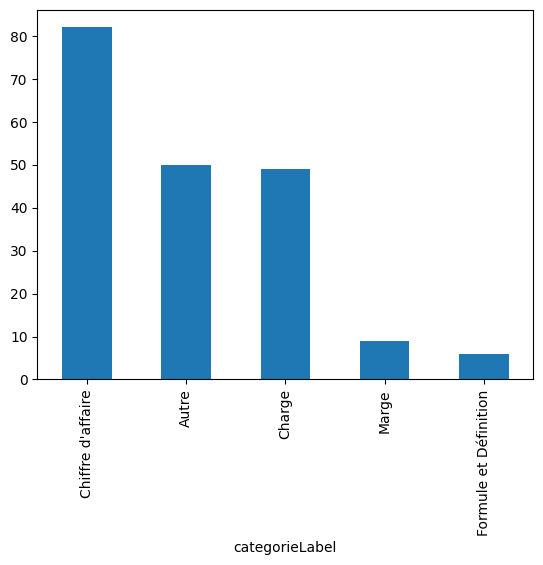

In [78]:
pd.DataFrame(lst)["categorieLabel"].value_counts().plot(kind='bar')